This notebook is used to compile all our models and compare them along with some standardized format. Make sure your code output fits as input to this standardized format, such that it only needs to be imported and can run from the get-go.

I'll also build some plotter to make this work well and of course ensure there is proper docstrings and comments

(If you want to make your folder importable, like I did with Code_Emiel, simply add an empty __init__.py to the folder)

In [1]:
import os
import sys

sys.path.append(os.getcwd())

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot(title, matrix, models, M):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), constrained_layout=True)
    sns.heatmap(
        matrix,
        annot=True,            # show the numbers
        fmt=".2f",             # two decimals
        cmap="viridis",
        xticklabels=models,
        yticklabels=models,
        mask=np.isnan(matrix), # hides NaN cells
        square=True,
        cbar_kws={'shrink': 0.6},
        ax=ax1
    )
    # cax = ax.imshow(matrix, cmap='viridis', interpolation='nearest')
    # fig.colorbar(cax, ax=ax)
    ax1.set_xticks(range(M))
    ax1.set_xticklabels(models, rotation=90)
    ax1.set_yticks(range(M))
    ax1.set_yticklabels(models)
    ax1.set_title(title, pad=20)

    cax = ax2.imshow(matrix, cmap='viridis', interpolation='nearest')
    fig.colorbar(cax, ax=ax2)
    ax2.set_xticks(range(len(models)))
    ax2.set_xticklabels(models, rotation=90)
    ax2.set_yticks(range(len(models)))
    ax2.set_yticklabels(models)
    ax2.set_title(title + "\n(same plot but with clearer x and y labels)", pad=20)
    fig.subplots_adjust(wspace=0.7)
    plt.show()

In [27]:
# Standard format

from typing import List, Tuple
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

class StandardFormat:
    def __init__(self, n_samples):
        self.detected_outliers = {}
        self.confidences = {}
        self.n_samples = n_samples

    def add_outlier_samples(self, model_name: str, outliers: List[str]):
        """
        model_name: str = the name of your model of which you want to add the outliers to the pool

        outliers: list = the list of sample/measurement names (don't add anything else besides that, just the names of the samples (sample_1, sample_4567, etc)) (the length of the list doesn't matter, it can be any length, ensuring the alpha is 0.05)

        Call this function to add identified samples to the data pool
        With that I mean the following:
        with a certain alpha value, you select which samples are identified to be outliers.

        For this alpha, make sure you take 0.05! (standard alpha value)

        This is important, else we're comparing apples with oranges.
        """
        
        assert all(isinstance(item, str) for item in outliers), "Outliers should be a list of strings"
        self.detected_outliers.update({model_name: outliers})

    def add_confidences(self, model_name: str, confidences: List[Tuple[str, float]]):
        """
        model_name: str = the name of your model of which you want to add the confidences to the pool

        confidences: list = the list of (sample_name, confidence values) (probabilities between 0 and 1 that this sample or measurement is an outlier) (don't add anything else besides that, just the confidence values)

        Call this function to add identified samples to the data pool
        We're specifically NOT working with alpha values in this one
        Ensure that the raw confidence values of something being an outlier are added here
        What is the confidence value? A probability between 0 and 1 that this sample or measurement is an outlier, with 1 being fully confident that it IS an outlier, and vice versa.
    
        Ensure that the length of the confidences list is the same as the length of the entire dataset (so make sure that all samples are in the list, and nothing more or less. I will assert this, it will crash if the length is off!).
        """
        if self.n_samples is not None and len(confidences) != self.n_samples:
            raise ValueError(f"Expected {self.n_samples} confidences, got {len(confidences)}")
        self.confidences.update({model_name: confidences})

    def compute_similarity_scores_detected_outliers(self, plot_results: bool = False):
        models = list(self.detected_outliers)
        M = len(models)
        matrix = np.zeros((M, M), dtype=float)

        for i, model_name in enumerate(models):
            si = set(self.detected_outliers[model_name])
            for j, other_model_name in enumerate(models):
                if i == j:
                    matrix[i, j] = np.nan  # Diagonal can be set to NaN or 0 as preferred
                else:
                    sj = set(self.detected_outliers[other_model_name])
                    union = len(si | sj)
                    matrix[i, j] = (len(si & sj) / union) if union else np.nan

        if plot_results:
            plot("Similarity Matrix of Detected Outliers", matrix, models, M)
        return models, matrix

    def compute_similarity_scores_confidences(self, plot_results: bool = False):
        models = list(self.confidences)
        M = len(models)
        sorted_confidences = {
            m: sorted(self.confidences[m], key=lambda x: x[0])
            for m in models
        }
        X = np.vstack([
            [conf for (_sid, conf) in sorted_confidences[m]]
            for m in models
        ])
        matrix = cosine_similarity(X)
        np.fill_diagonal(matrix, np.nan)

        if plot_results:
            plot("Similarity Matrix of Confidences", matrix, models, M)
        return models, matrix

standard_format = StandardFormat(20446)

**Emiel's code:**

In [28]:
from Code_Emiel import Elliptic_Envelope as elliptic_envelope_emiel
from Code_Emiel import Robust_PCA as rpca_emiel

outliers, confidences = elliptic_envelope_emiel.main()
standard_format.add_outlier_samples("Elliptic Envelope Emiel", outliers)
standard_format.add_confidences("Elliptic Envelope Emiel", confidences)

rpca_outliers, rpca_confidences, pyrpca_outliers, pyrpca_confidences = rpca_emiel.main()
standard_format.add_outlier_samples("Robust PCA Emiel (rpca)", rpca_outliers)
standard_format.add_confidences("Robust PCA Emiel (rpca)", rpca_confidences)
standard_format.add_outlier_samples("Robust PCA Emiel (pyrpca)", pyrpca_outliers)
standard_format.add_confidences("Robust PCA Emiel (pyrpca)", pyrpca_confidences)

Max: 3700.222357665773 Min: 0.010065982414065654
382 outliers (2.06% of samples):
['sample_10076', 'sample_10104', 'sample_10152', 'sample_10203', 'sample_10224', 'sample_10270', 'sample_10306', 'sample_10332', 'sample_10377', 'sample_10384', 'sample_10388', 'sample_10444', 'sample_10652', 'sample_10659', 'sample_10669', 'sample_10821', 'sample_1093', 'sample_10930', 'sample_10944', 'sample_1096', 'sample_10963', 'sample_10967', 'sample_10973', 'sample_11030', 'sample_11067', 'sample_11131', 'sample_11239', 'sample_11280', 'sample_11287', 'sample_11316', 'sample_11331', 'sample_11414', 'sample_11465', 'sample_11534', 'sample_1159', 'sample_11601', 'sample_11796', 'sample_11820', 'sample_11860', 'sample_11864', 'sample_11865', 'sample_11871', 'sample_11886', 'sample_11924', 'sample_11946', 'sample_11987', 'sample_12054', 'sample_12148', 'sample_12156', 'sample_12198', 'sample_12205', 'sample_1222', 'sample_12284', 'sample_12286', 'sample_12298', 'sample_123', 'sample_12402', 'sample_124

**Nicolas' code:**

**Abhinav's code:**

**Patricia's code:**

**Run Evaluation**

C:\Users\Emiel\AppData\Local\Temp\ipykernel_33856\153441366.py:34: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.7)


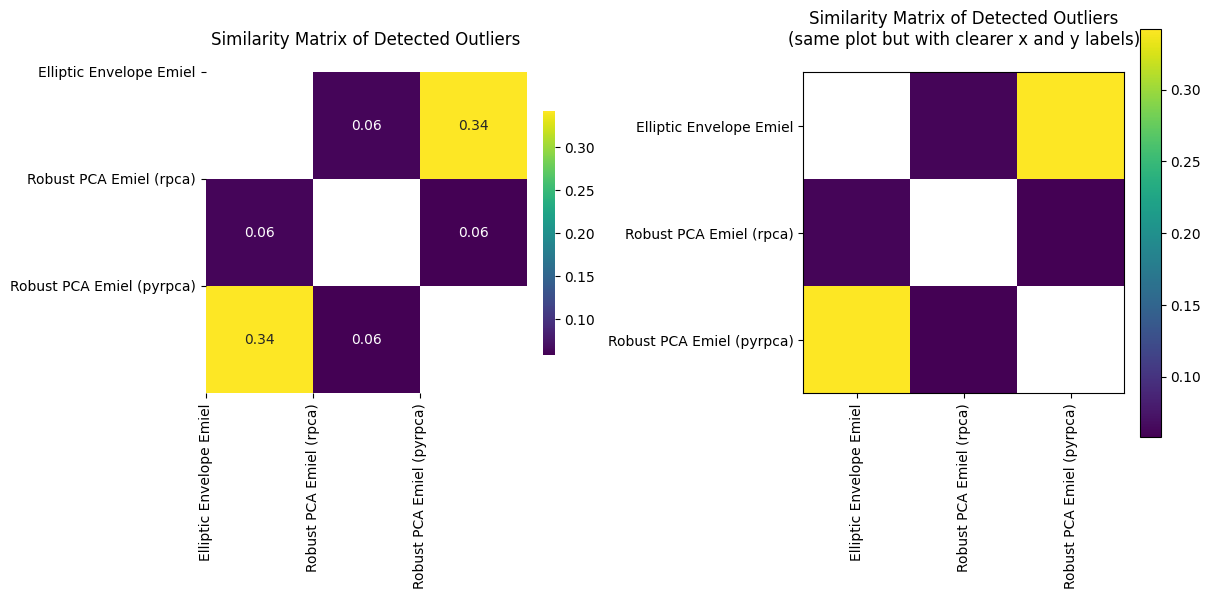

C:\Users\Emiel\AppData\Local\Temp\ipykernel_33856\153441366.py:34: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(wspace=0.7)


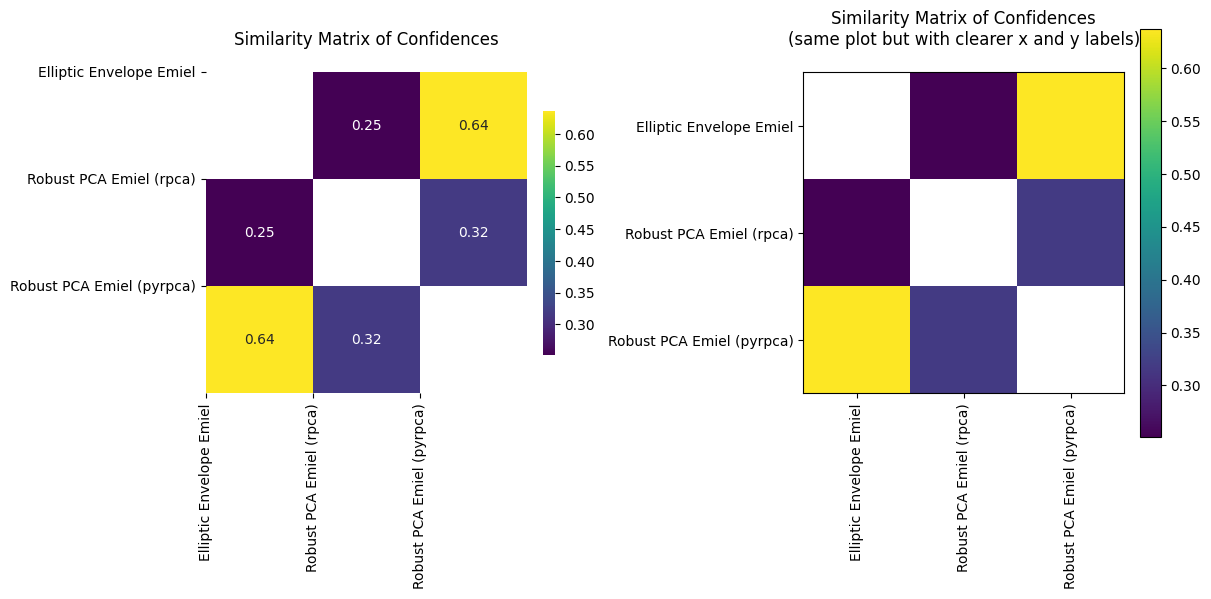

(['Elliptic Envelope Emiel',
  'Robust PCA Emiel (rpca)',
  'Robust PCA Emiel (pyrpca)'],
 array([[       nan, 0.25146987, 0.63691694],
        [0.25146987,        nan, 0.31669607],
        [0.63691694, 0.31669607,        nan]]))

In [33]:
standard_format.compute_similarity_scores_detected_outliers(plot_results=True)
standard_format.compute_similarity_scores_confidences(plot_results=True)